In [73]:
import pandas as pd
import numpy as np
from collections import Counter

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import linear_model

In [2]:
data_location = ''

In [3]:
# Read in the data set
file_name = 'competition_starter.csv'
starter_data = pd.read_csv(data_location + file_name, header=0, index_col=0)

In [4]:
# First, read in the csv
file_name_employment = 'competition_employment.csv'
employment_data = pd.read_csv(data_location + file_name_employment, header=0)

In [5]:
# Perform the merge
common_key = 'soa'

hack_data = starter_data.merge(employment_data, on=common_key, how='left')

In [6]:
# First, read in the csv
file_name_waiting = 'competition_waiting.csv'
waiting_data = pd.read_csv(data_location + file_name_waiting)

In [7]:
waiting_data['gp_month'] = [int(i.split('-')[0]) for i in waiting_data['quarter_end']]
waiting_data['gp_year'] = [int(i.split('-')[1]) for i in waiting_data['quarter_end']]

In [8]:
waiting_data = waiting_data.drop(['quarter_end'], 1)

In [9]:
# Perform the merge
common_key = ['hsc_trust', 'gp_month', 'gp_year']

hack_data = hack_data.merge(waiting_data, on=common_key, how='left')

In [10]:
holdout = pd.read_csv(data_location + "holdout.csv", header=0, index_col=0)

In [11]:
#check to see if holdout set shares the same col names as the dataset, so not all are shared by the results
shared_col_names = np.intersect1d(np.asarray(list(holdout)), np.asarray(list(hack_data)))
holdout_list = [col for col in holdout.columns  if col not in shared_col_names]
holdout_list

['record_id',
 'All_usual_residents',
 'Very_good_health',
 'Good_health',
 'Fair_health',
 'Bad_health',
 'Very_bad_health',
 'quarter_end']

In [12]:
holdout = holdout.drop([ 'All_usual_residents',
 'Very_good_health',
 'Good_health',
 'Fair_health',
 'Bad_health',
 'Very_bad_health',
 'quarter_end'], 1)

In [13]:
hack_data['record_id'] = list(range(hack_data.shape[0]))

In [14]:
train = hack_data
test = holdout

In [15]:
##display the first five rows of the train dataset.
train.head(5)

,gp_practice,gp_year,gp_month,quality,eastings,northings,country,nhs_ha,longitude,latitude,...,plastic_surgery,radiology,rehabilitation,restorative_dentistry,rheumatology,t_o_surgery,thoracic_medicine,thoracic_surgery,urology,record_id
0,900207,2014,1,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,900207,2014,2,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,900207,2014,3,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,197.0,0.0,28.0,1257.0,1459.0,10356.0,1518.0,97.0,2153.0,2
3,900207,2014,4,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,900207,2014,5,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [16]:
##display the first five rows of the test dataset.
test.head(5)

,record_id,gp_practice,gp_year,gp_month,quality,eastings,northings,country,nhs_ha,longitude,...,palliative_medicine,plastic_surgery,radiology,rehabilitation,restorative_dentistry,rheumatology,t_o_surgery,thoracic_medicine,thoracic_surgery,urology
0,0,900207,2017,6,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,13.0,100.0,0.0,48.0,1878.0,3241.0,23798.0,1733.0,55.0,3924.0
1,1,900207,2017,7,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,900207,2017,8,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,900209,2017,6,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,13.0,100.0,0.0,48.0,1878.0,3241.0,23798.0,1733.0,55.0,3924.0
4,4,900209,2017,7,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['record_id']
test_ID = test['record_id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("record_id", axis = 1, inplace = True)
test.drop("record_id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (9293, 194) 
The test data size before dropping Id feature is : (783, 193) 

The train data size after dropping Id feature is : (9293, 193) 
The test data size after dropping Id feature is : (783, 192) 


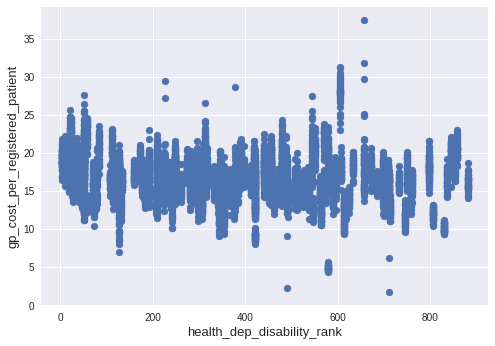

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = train['health_dep_disability_rank'], y = train['gp_cost_per_registered_patient'])
plt.ylabel('gp_cost_per_registered_patient', fontsize=13)
plt.xlabel('health_dep_disability_rank', fontsize=13)
plt.show()

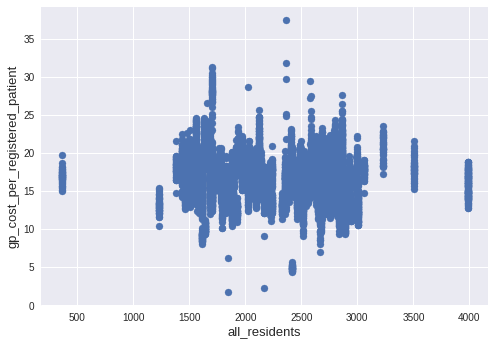

In [19]:
fig, ax = plt.subplots()
ax.scatter(x = train['all_residents'], y = train['gp_cost_per_registered_patient'])
plt.ylabel('gp_cost_per_registered_patient', fontsize=13)
plt.xlabel('all_residents', fontsize=13)
plt.show()


 mu = 16.68 and sigma = 2.92



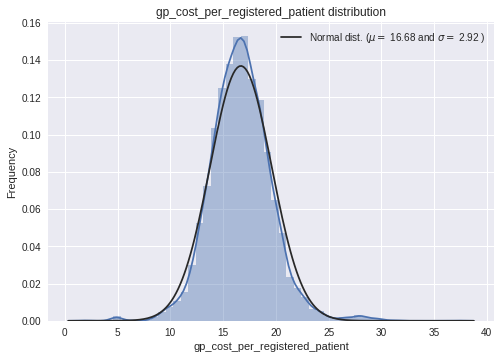

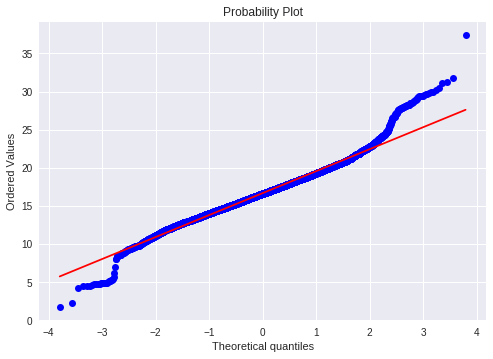

In [20]:
sns.distplot(train['gp_cost_per_registered_patient'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['gp_cost_per_registered_patient'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('gp_cost_per_registered_patient distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['gp_cost_per_registered_patient'], plot=plt)
plt.show()


 mu = 2.86 and sigma = 0.17



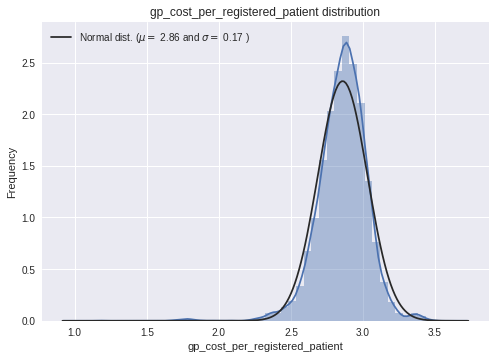

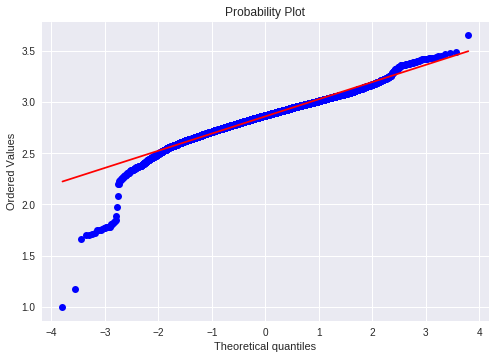

In [21]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["gp_cost_per_registered_patient"] = np.log1p(train["gp_cost_per_registered_patient"])

#Check the new distribution 
sns.distplot(train['gp_cost_per_registered_patient'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['gp_cost_per_registered_patient'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('gp_cost_per_registered_patient distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['gp_cost_per_registered_patient'], plot=plt)
plt.show()

In [22]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.gp_cost_per_registered_patient.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['gp_cost_per_registered_patient'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (10076, 192)


In [23]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
accident_emergency,68.132195
paediatric_surgery,68.132195
paediatric_dentistry,68.132195
anaesthetics,68.132195
audiological,68.132195
cardiac_surgery,68.132195
cardiology,68.132195
orthodontics,68.132195
oral_surgery,68.132195
ophthalmology,68.132195


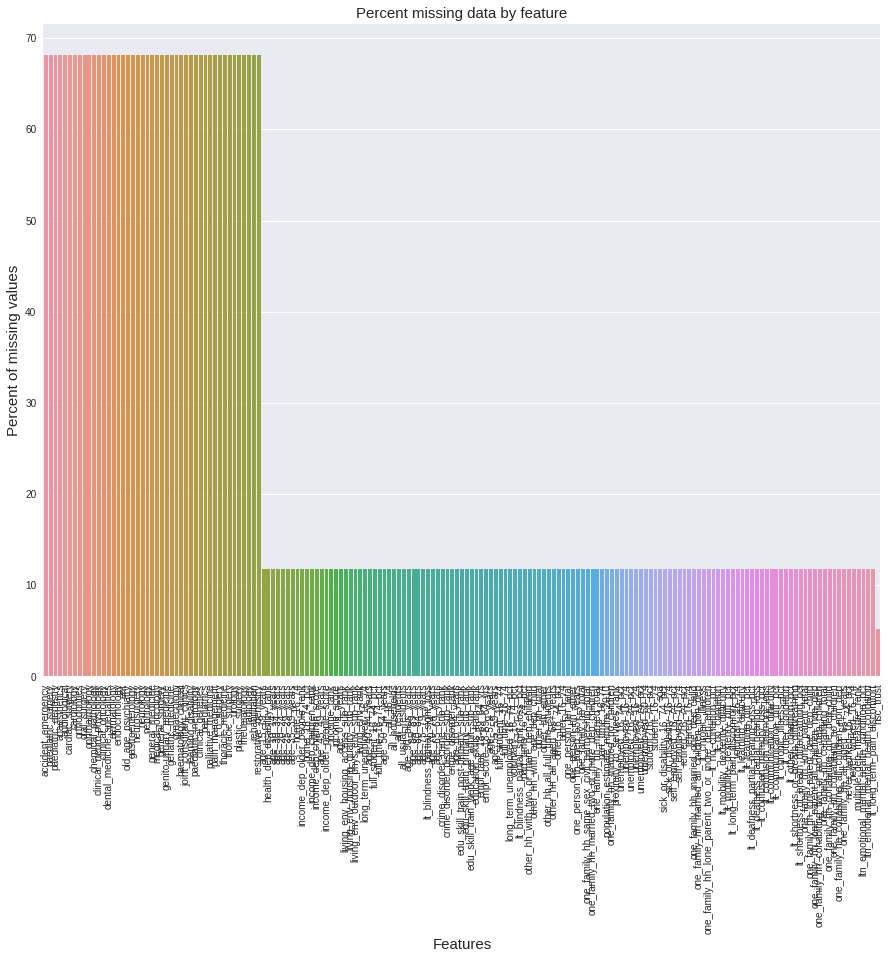

In [24]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

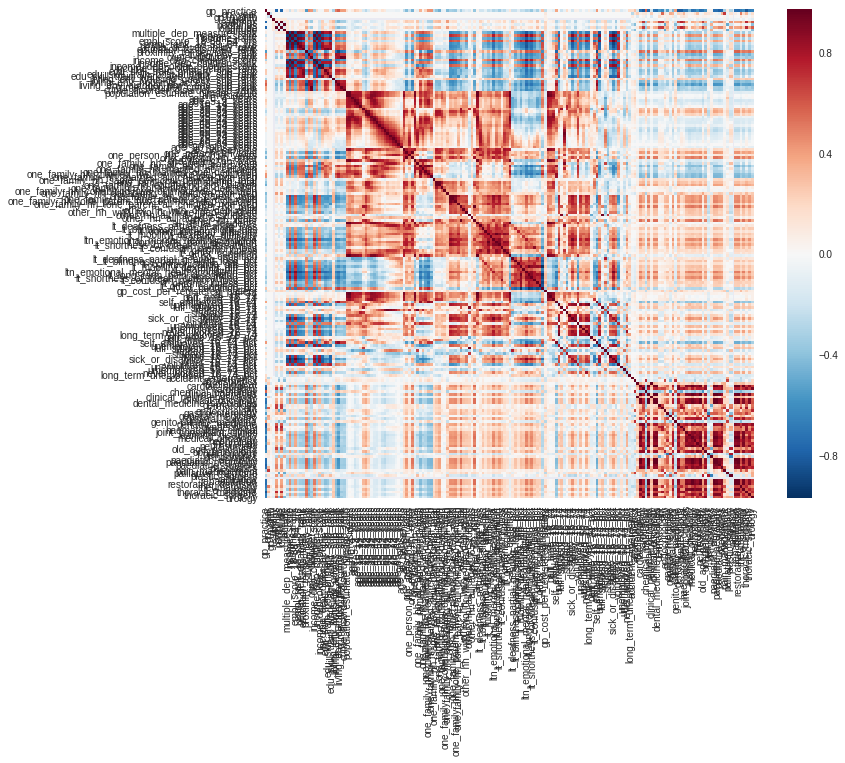

In [25]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [26]:
missing_data_list = missing_data.index.tolist()

In [27]:
missing_cat_data_list = [col for col in missing_data_list if all_data[col].dtype == 'O']

In [28]:
for col in missing_cat_data_list:
    all_data[col] = all_data[col].fillna("None")

In [29]:
missing_num_data_list = [col for col in missing_data_list if all_data[col].dtype == 'float64']

In [30]:
missing_starter_num_data_list = [col for col in missing_num_data_list if col in starter_data.columns]
missing_employment_num_data_list = [col for col in missing_num_data_list if col in employment_data.columns]
missing_waiting_num_data_list = [col for col in missing_num_data_list if col in waiting_data.columns]

In [31]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
for col in missing_starter_num_data_list:
    all_data[col] = all_data[col].transform(lambda x: x.fillna(x.median()))

In [32]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
for col in missing_employment_num_data_list:
    all_data[col] = all_data.groupby(['soa'])[col].transform(lambda x: x.fillna(x.median()))

In [33]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
for col in missing_waiting_num_data_list:
    all_data[col] = all_data.groupby(['hsc_trust', 'gp_month', 'gp_year'])[col].transform(lambda x: x.fillna(x.median()))

In [34]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
for col in missing_waiting_num_data_list:
    all_data[col] = all_data.groupby(['gp_month', 'gp_year'])[col].transform(lambda x: x.fillna(x.median()))

In [35]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
for col in missing_waiting_num_data_list:
    all_data[col] = all_data.groupby(['gp_year'])[col].transform(lambda x: x.fillna(x.median()))

In [36]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
for col in missing_num_data_list:
    all_data[col] = all_data[col].transform(lambda x: x.fillna(x.median()))

In [37]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [38]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [39]:
num_to_cat_columns = [col for col in numeric_feats if len(set(all_data[col])) < 15]

In [40]:
for col in num_to_cat_columns:
    all_data[col] = all_data[col].apply(str)

In [41]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
full_student_16_74_pct,9.683578
full_student_16_74,8.379101
plastic_surgery,4.760678
genito-urinary_medicine,4.686252
thoracic_surgery,4.468954
student_16_74_pct,4.397533
joint_consultant_clinics,4.184609
age_20_24_years,4.037964
paediatric_surgery,3.906245
medical_oncology,3.879447


In [44]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index.tolist()
del skewed_features[skewed_features.index('longitude')]
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 164 skewed numerical features to Box Cox transform


In [47]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.to_csv('/home/mark/Documents/Kaggle_Projects/Allstate-Data-Hack-2017/input/train.csv')
test.to_csv('/home/mark/Documents/Kaggle_Projects/Allstate-Data-Hack-2017/input/test.csv')

In [48]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(10076, 920)


In [49]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.to_csv('/home/mark/Documents/Kaggle_Projects/Allstate-Data-Hack-2017/input/train_dummy.csv')
test.to_csv('/home/mark/Documents/Kaggle_Projects/Allstate-Data-Hack-2017/input/test_dummy.csv')

In [50]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [51]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [52]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [53]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [54]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [55]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [56]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, nthread = -1)

In [57]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [58]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.


Lasso score: 0.1834 (0.0421)



/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [59]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.

ElasticNet score: 0.1841 (0.0416)



/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [60]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1794 (0.0456)



In [61]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1633 (0.0521)



In [62]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1654 (0.0483)



In [63]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1594 (0.0483)



In [64]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [65]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.

 Averaged base models score: 0.1696 (0.0416)



In [66]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [67]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.

Stacking Averaged models score: 0.1647 (0.0524)


In [68]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [69]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.

0.0650170450863


In [70]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0639418853706


In [71]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.077950873306


In [77]:
predistions_df = pd.DataFrame({
    'stacked':stacked_train_pred,
    'xgb':xgb_train_pred,
    'lgb':lgb_train_pred
})

In [78]:
reg = linear_model.LinearRegression()
reg.fit (predistions_df.values, y_train)
print(reg.coef_)

[-0.80245168  0.78280355  1.02790971]


In [82]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*-0.80245168 +
               xgb_train_pred*0.78280355 + lgb_train_pred*1.02790971 ))

RMSLE score on train data:
0.0870161887168


In [83]:
ensemble = stacked_pred*-0.80245168 + xgb_pred*0.78280355 + lgb_pred*1.02790971

In [84]:
sub = pd.DataFrame()
sub['record_id'] = test_ID
sub['prediction'] = ensemble
sub.to_csv('submission.csv',index=False)